### Setting up runtime

In [ ]:
!pip install pandas matplotlib

In [ ]:
!pip install -U scikit-learn

In [ ]:
!pip install seaborn

In [6]:
from user_agents import parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from textwrap import wrap
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import OneClassSVM
import joblib

### Loading Data

In [17]:
f=open('../../../Downloads/benign/BlueCoat_Large.webgateway')

In [18]:
print(f.readline())

[02/Aug/2011:22:00:00 -0700] "user_1" 0.0.0.0 0.0.0.0  9080 200 TCP_HIT "GET http://games.maktoob.com/smart/gamesCH1/gimages/smart1040.jpeg HTTP/1.0" "unknown"  "low risk" "image/jpeg" 2370 409 "Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US) AppleWebKit/534.10 (KHTML, like Gecko) Chrome/8.0.552.237 Safari/534.10" "i1.makcdn.com" "-" "0" "" "-"



In [19]:
data =[]
for x in f:
    data.append(x)

In [20]:
f.close()

In [21]:
benign=pd.DataFrame(data)

In [22]:
benign.columns=['user_agent']

In [8]:
benign.head()

,user_agent
0,"[02/Aug/2011:22:00:00 -0700] ""user_2"" 0.0.0.0 ..."
1,"[02/Aug/2011:22:00:00 -0700] ""user_3"" 0.0.0.0 ..."
2,"[02/Aug/2011:22:00:00 -0700] ""user_4"" 0.0.0.0 ..."
3,"[02/Aug/2011:22:00:00 -0700] ""user_5"" 0.0.0.0 ..."
4,"[02/Aug/2011:22:00:00 -0700] ""user_6"" 0.0.0.0 ..."


In [9]:
benign.tail()

,user_agent
1424284,"[02/Aug/2011:23:27:37 -0700] ""user_425"" 0.0.0...."
1424285,"[02/Aug/2011:23:27:37 -0700] ""user_426"" 0.0.0...."
1424286,"[02/Aug/2011:23:27:37 -0700] ""user_427"" 0.0.0...."
1424287,"[02/Aug/2011:23:27:37 -0700] ""user_428"" 0.0.0...."
1424288,"[02/Aug/2011:23:27:37 -0700] ""user_429"" 0.0.0...."


### Data wrangling and sampling

In [10]:
a=parse(benign['user_agent'][3])

In [12]:
a.browser.family

'Other'

In [92]:
a.ua_string

'[02/Aug/2011:22:00:00 -0700] "user_5" 0.0.0.0 0.0.0.0  9080 0 TCP_ERR_MISS "unknown -/ HTTP/1.0" "unknown"  "low risk" "-" 0 35 "-" "-" "-" "0" "" "-"\n'

In [15]:
benign['timestamp']=benign['user_agent'].apply(lambda x: re.findall(r'^\[(.+?)\]',x)[0])

In [16]:
benign['timestamp_obj']=benign['timestamp'].apply(lambda x:pd.to_datetime(x,format='%d/%b/%Y:%H:%M:%S -0700',errors='coerce'))

In [17]:
benign.isnull().sum()

user_agent       0
timestamp        0
timestamp_obj    0
dtype: int64

In [18]:
benign['timestamp_obj'].max(),benign['timestamp_obj'].min()

(Timestamp('2011-08-02 23:27:37'), Timestamp('2011-08-02 22:00:00'))

In [19]:
benign['min']=benign['timestamp_obj'].apply(lambda x:(x.hour,x.minute))

In [20]:
benign.head()

,user_agent,timestamp,timestamp_obj,min
0,"[02/Aug/2011:22:00:00 -0700] ""user_2"" 0.0.0.0 ...",02/Aug/2011:22:00:00 -0700,2011-08-02 22:00:00,"(22, 0)"
1,"[02/Aug/2011:22:00:00 -0700] ""user_3"" 0.0.0.0 ...",02/Aug/2011:22:00:00 -0700,2011-08-02 22:00:00,"(22, 0)"
2,"[02/Aug/2011:22:00:00 -0700] ""user_4"" 0.0.0.0 ...",02/Aug/2011:22:00:00 -0700,2011-08-02 22:00:00,"(22, 0)"
3,"[02/Aug/2011:22:00:00 -0700] ""user_5"" 0.0.0.0 ...",02/Aug/2011:22:00:00 -0700,2011-08-02 22:00:00,"(22, 0)"
4,"[02/Aug/2011:22:00:00 -0700] ""user_6"" 0.0.0.0 ...",02/Aug/2011:22:00:00 -0700,2011-08-02 22:00:00,"(22, 0)"


In [21]:
grouped_benign=benign.groupby('min', group_keys=False)

#### Time Distribution of Records

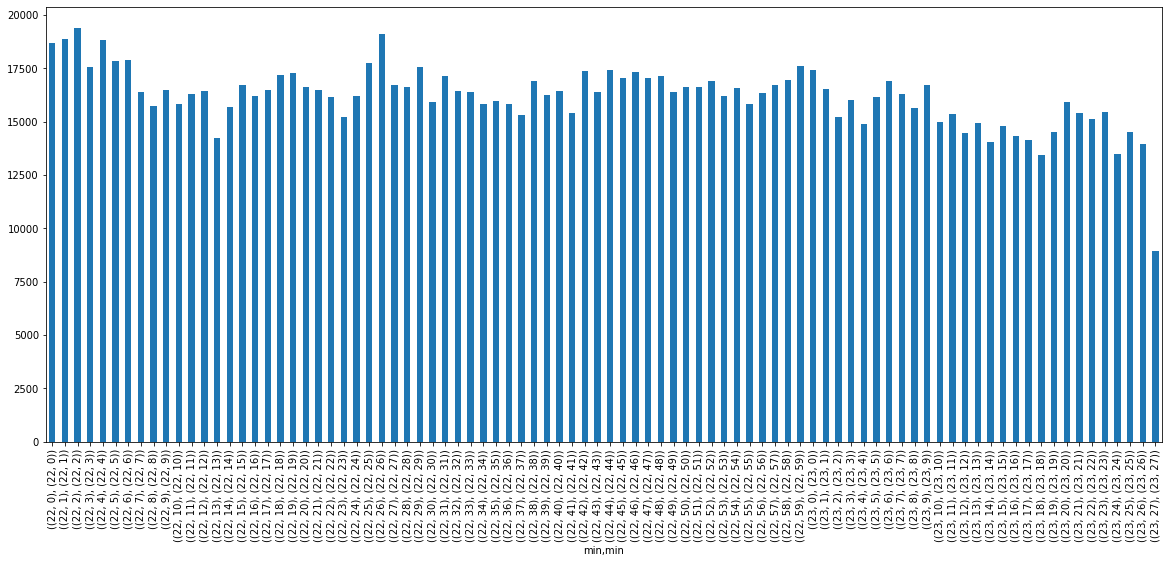

In [22]:
plt.figure(figsize=(20,8))
grouped_benign['min'].value_counts().plot(kind='bar')

#### Time slice sampling of 0.5% due to modest computing resources

In [23]:
sample=grouped_benign.apply(lambda x: x.sample(frac=0.005)).reset_index()

In [24]:
sample

,index,user_agent,timestamp,timestamp_obj,min
0,4351,"[02/Aug/2011:22:00:15 -0700] ""user_353"" 0.0.0....",02/Aug/2011:22:00:15 -0700,2011-08-02 22:00:15,"(22, 0)"
1,13740,"[02/Aug/2011:22:00:44 -0700] ""user_242"" 0.0.0....",02/Aug/2011:22:00:44 -0700,2011-08-02 22:00:44,"(22, 0)"
2,105,"[02/Aug/2011:22:00:00 -0700] ""user_107"" 0.0.0....",02/Aug/2011:22:00:00 -0700,2011-08-02 22:00:00,"(22, 0)"
3,5487,"[02/Aug/2011:22:00:19 -0700] ""user_489"" 0.0.0....",02/Aug/2011:22:00:19 -0700,2011-08-02 22:00:19,"(22, 0)"
4,2861,"[02/Aug/2011:22:00:10 -0700] ""user_363"" 0.0.0....",02/Aug/2011:22:00:10 -0700,2011-08-02 22:00:10,"(22, 0)"
...,...,...,...,...,...
7117,1419533,"[02/Aug/2011:23:27:16 -0700] ""user_174"" 0.0.0....",02/Aug/2011:23:27:16 -0700,2011-08-02 23:27:16,"(23, 27)"
7118,1417352,"[02/Aug/2011:23:27:07 -0700] ""user_493"" 0.0.0....",02/Aug/2011:23:27:07 -0700,2011-08-02 23:27:07,"(23, 27)"
7119,1422047,"[02/Aug/2011:23:27:28 -0700] ""user_188"" 0.0.0....",02/Aug/2011:23:27:28 -0700,2011-08-02 23:27:28,"(23, 27)"
7120,1422930,"[02/Aug/2011:23:27:32 -0700] ""user_71"" 0.0.0.0...",02/Aug/2011:23:27:32 -0700,2011-08-02 23:27:32,"(23, 27)"


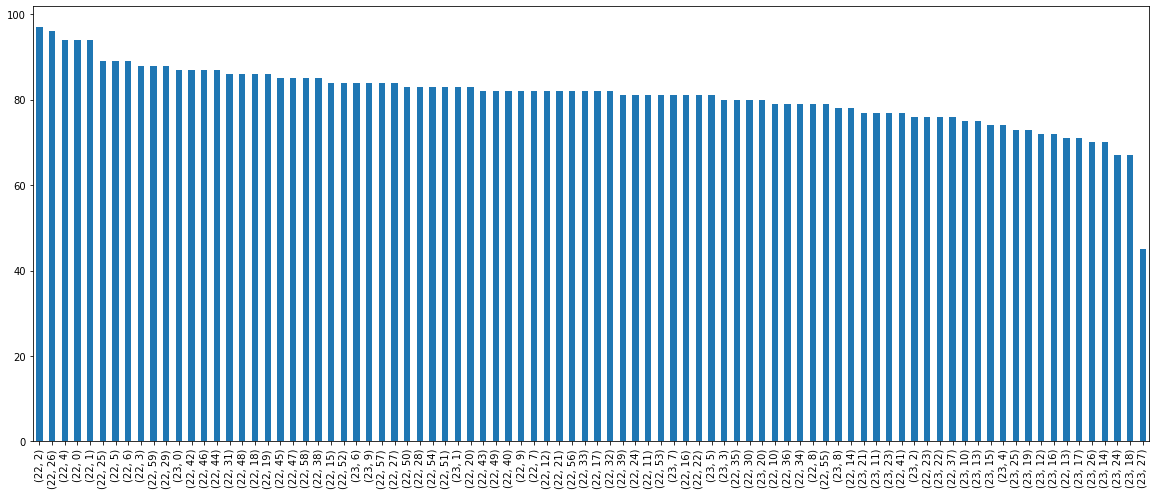

In [25]:
plt.figure(figsize=(20,8))
sample['min'].value_counts().plot(kind='bar')

#### Data parsing/wrangling

In [26]:
sample['user_id']=benign['user_agent'].apply(lambda x: re.findall(r'user_\d+',x)[0])

In [27]:
sample['browser_family']=sample['user_agent'].apply(lambda x:parse(x).browser.family)

In [28]:
sample['browser_version']=sample['user_agent'].apply(lambda x:parse(x).browser.version_string)

In [29]:
sample['os_family']=sample['user_agent'].apply(lambda x:parse(x).os.family)

In [30]:
sample['os_version']=sample['user_agent'].apply(lambda x:parse(x).os.version_string)

In [31]:
sample['device_family']=sample['user_agent'].apply(lambda x:parse(x).device.family)

In [32]:
sample['device_brand']=sample['user_agent'].apply(lambda x:parse(x).device.brand)

In [33]:
sample['device_model']=sample['user_agent'].apply(lambda x:parse(x).device.model)

In [34]:
sample['is_mobile']=sample['user_agent'].apply(lambda x:parse(x).is_mobile)

In [35]:
sample['is_tablet']=sample['user_agent'].apply(lambda x:parse(x).is_tablet)

In [36]:
sample['is_pc']=sample['user_agent'].apply(lambda x:parse(x).is_pc)

In [37]:
sample['is_touch_capable']=sample['user_agent'].apply(lambda x:parse(x).is_touch_capable)

In [38]:
sample['is_bot']=sample['user_agent'].apply(lambda x:parse(x).is_bot)

In [39]:
sample=pd.DataFrame(sample)

In [40]:
sample

,index,user_agent,timestamp,timestamp_obj,min,user_id,browser_family,browser_version,os_family,os_version,device_family,device_brand,device_model,is_mobile,is_tablet,is_pc,is_touch_capable,is_bot
0,4351,"[02/Aug/2011:22:00:15 -0700] ""user_353"" 0.0.0....",02/Aug/2011:22:00:15 -0700,2011-08-02 22:00:15,"(22, 0)",user_2,Opera Mobile,11.10,Symbian OS,,Generic Smartphone,Generic,Smartphone,True,False,False,False,False
1,13740,"[02/Aug/2011:22:00:44 -0700] ""user_242"" 0.0.0....",02/Aug/2011:22:00:44 -0700,2011-08-02 22:00:44,"(22, 0)",user_3,Firefox,5.0,Windows,7,Other,None,None,False,False,True,False,False
2,105,"[02/Aug/2011:22:00:00 -0700] ""user_107"" 0.0.0....",02/Aug/2011:22:00:00 -0700,2011-08-02 22:00:00,"(22, 0)",user_4,Firefox,5.0,Windows,XP,Other,None,None,False,False,True,False,False
3,5487,"[02/Aug/2011:22:00:19 -0700] ""user_489"" 0.0.0....",02/Aug/2011:22:00:19 -0700,2011-08-02 22:00:19,"(22, 0)",user_5,Firefox,3.6.8,Windows,XP,Other,None,None,False,False,True,False,False
4,2861,"[02/Aug/2011:22:00:10 -0700] ""user_363"" 0.0.0....",02/Aug/2011:22:00:10 -0700,2011-08-02 22:00:10,"(22, 0)",user_6,Other,,Other,,Other,None,None,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7117,1419533,"[02/Aug/2011:23:27:16 -0700] ""user_174"" 0.0.0....",02/Aug/2011:23:27:16 -0700,2011-08-02 23:27:16,"(23, 27)",user_119,Firefox,6.0,Windows,XP,Other,None,None,False,False,True,False,False
7118,1417352,"[02/Aug/2011:23:27:07 -0700] ""user_493"" 0.0.0....",02/Aug/2011:23:27:07 -0700,2011-08-02 23:27:07,"(23, 27)",user_120,IE,9.0,Windows,7,Other,None,None,False,False,True,False,False
7119,1422047,"[02/Aug/2011:23:27:28 -0700] ""user_188"" 0.0.0....",02/Aug/2011:23:27:28 -0700,2011-08-02 23:27:28,"(23, 27)",user_121,Firefox,5.0,Windows,XP,Other,None,None,False,False,True,False,False
7120,1422930,"[02/Aug/2011:23:27:32 -0700] ""user_71"" 0.0.0.0...",02/Aug/2011:23:27:32 -0700,2011-08-02 23:27:32,"(23, 27)",user_122,Firefox,5.0,Windows,XP,Other,None,None,False,False,True,False,False


### Understanding Data Features and Summary Statistics

In [41]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7122 entries, 0 to 7121
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   index             7122 non-null   int64         
 1   user_agent        7122 non-null   object        
 2   timestamp         7122 non-null   object        
 3   timestamp_obj     7122 non-null   datetime64[ns]
 4   min               7122 non-null   object        
 5   user_id           7122 non-null   object        
 6   browser_family    7122 non-null   object        
 7   browser_version   7122 non-null   object        
 8   os_family         7122 non-null   object        
 9   os_version        7122 non-null   object        
 10  device_family     7122 non-null   object        
 11  device_brand      608 non-null    object        
 12  device_model      608 non-null    object        
 13  is_mobile         7122 non-null   bool          
 14  is_tablet         7122 n

#### Average of  14.2 records per user id

In [42]:
sample['user_id'].value_counts().max(),sample['user_id'].value_counts().min(),sample['user_id'].value_counts().mean()

(15, 14, 14.244)

#### Charts and Tables Showing Summary Statistics

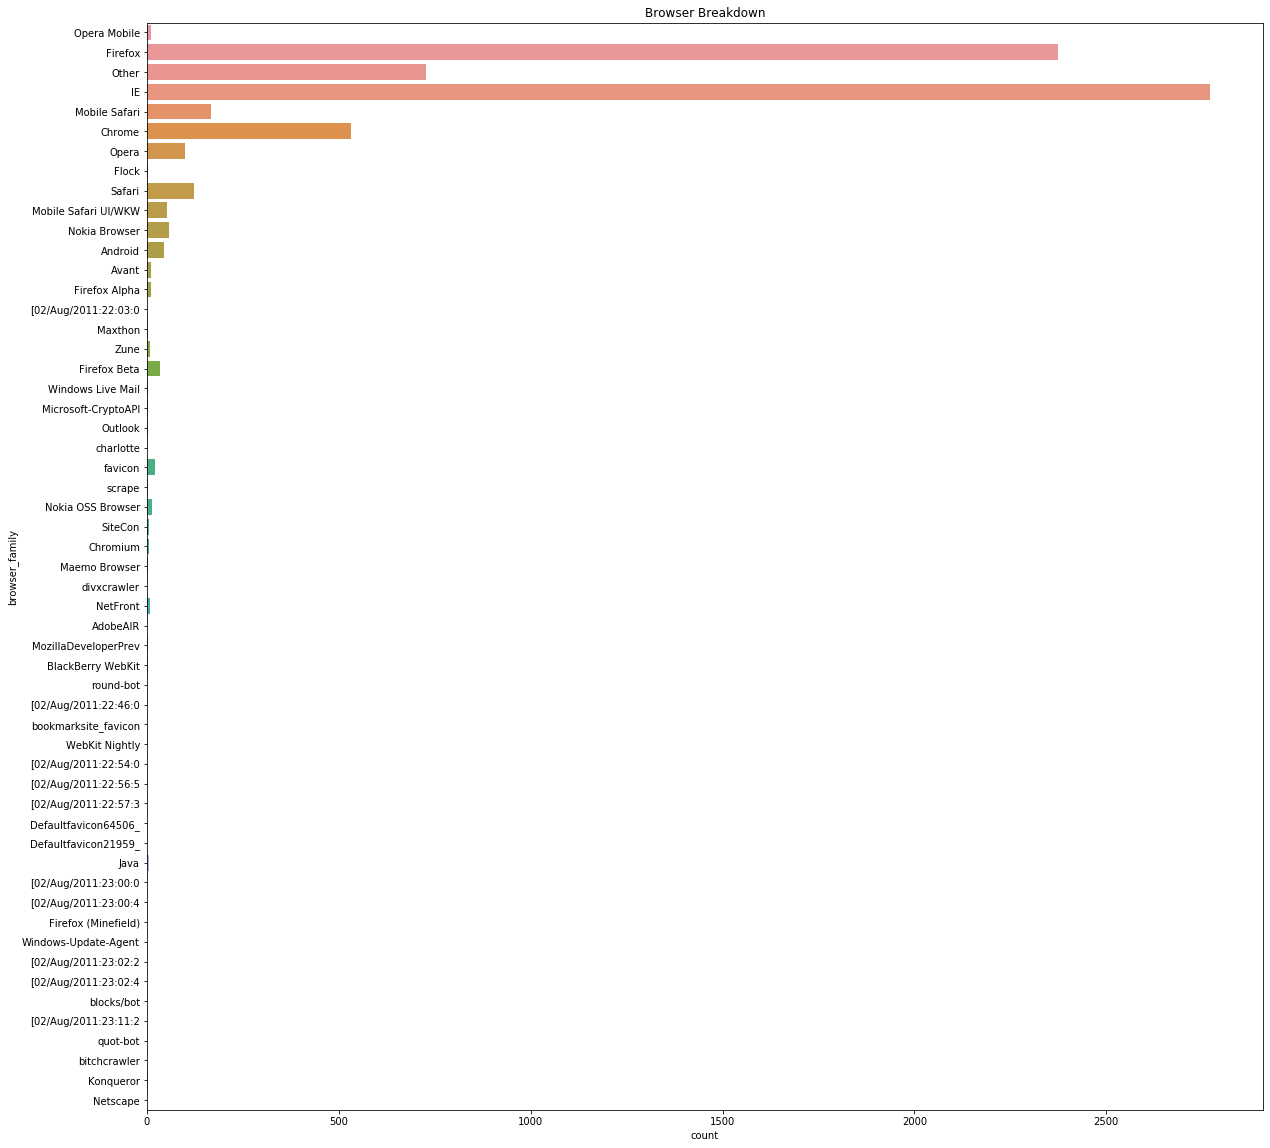

In [43]:
plt.figure(figsize=(20,20))
plt.title("Browser Breakdown")
ax=sns.countplot(y='browser_family',data=sample)
labels=[l.get_text()[:20] for l in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.show()

In [44]:
browser_cnt=pd.DataFrame(sample['browser_family'].value_counts()).reset_index()
browser_cnt.columns=['browser_family','counts']
browser_cnt

,browser_family,counts
0,IE,2770
1,Firefox,2373
2,Other,726
3,Chrome,531
4,Mobile Safari,167
5,Safari,123
6,Opera,98
7,Nokia Browser,58
8,Mobile Safari UI/WKWebView,52
9,Android,45


#### Device data is sparse and will not make for good features when developing model

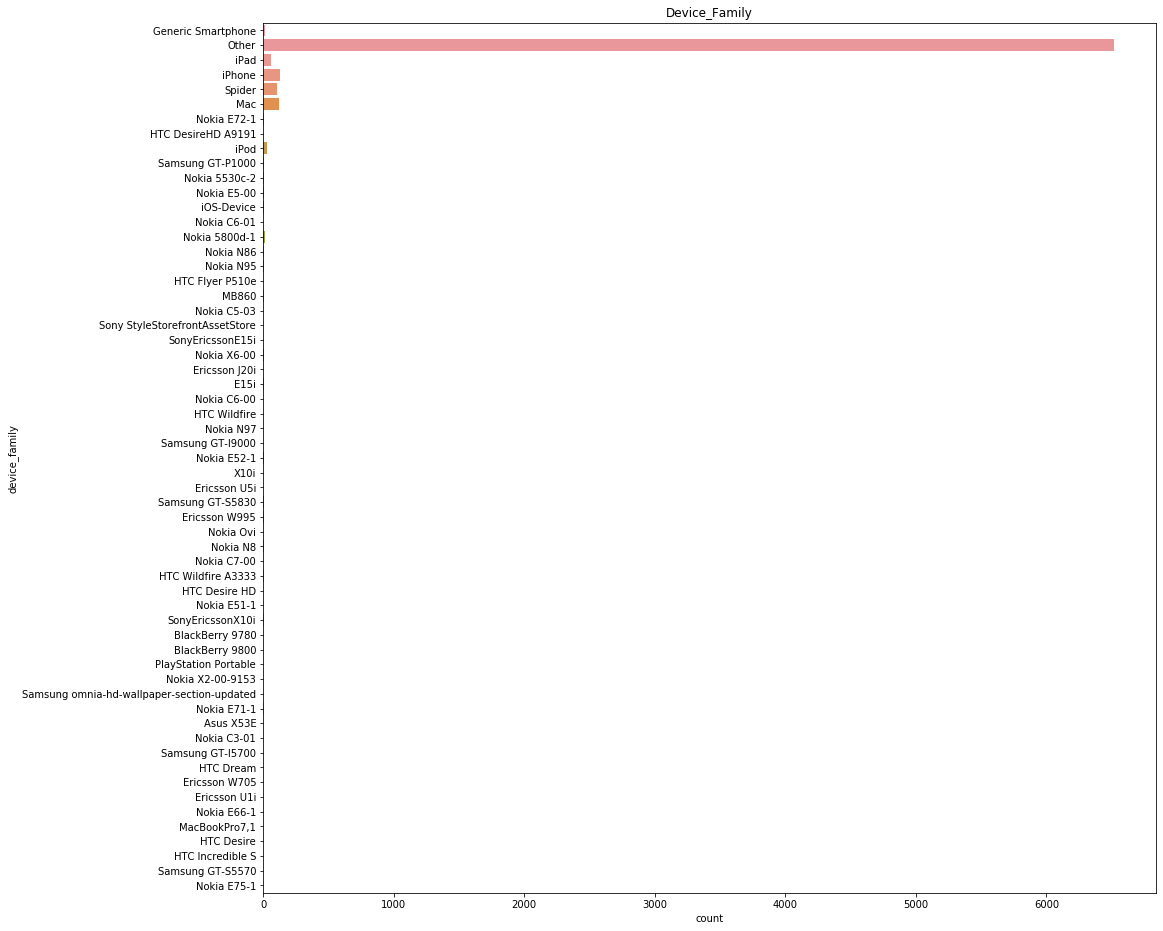

In [45]:
plt.figure(figsize=(16,16))
plt.title("Device_Family")
ax=sns.countplot(y='device_family', data=sample)

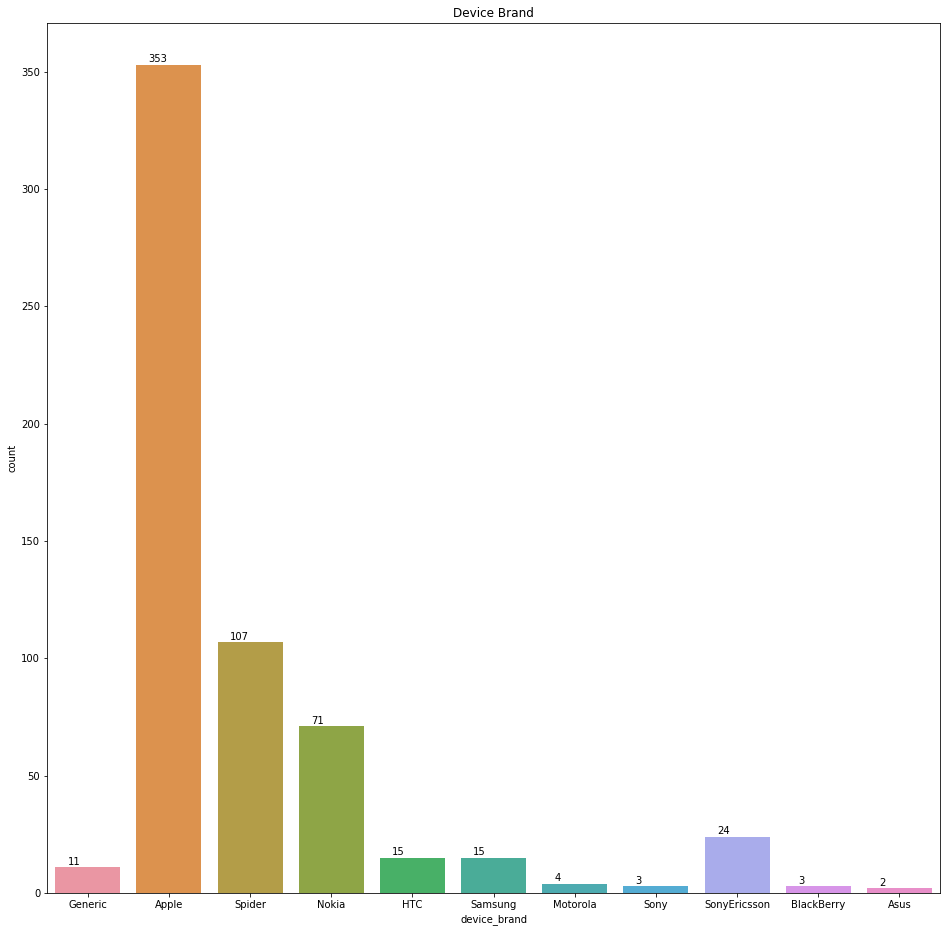

In [204]:
plt.figure(figsize=(16,16))
plt.title("Device Brand")
ax=sns.countplot(x='device_brand', data=sample)
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
plt.show()


#### Operating System proportions

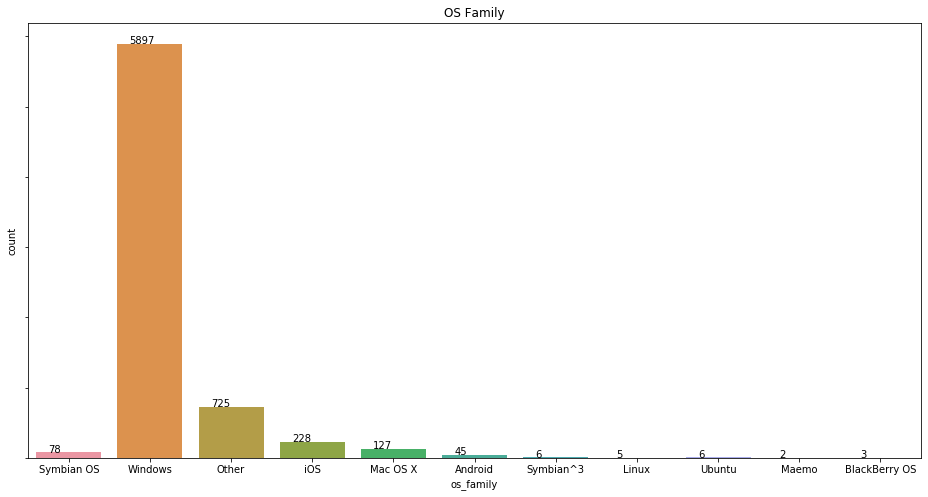

In [206]:
plt.figure(figsize=(16,8))
plt.title("OS Family")
ax=sns.countplot(x='os_family',data=sample)
labels=[l.get_text()[:20] for l in ax.get_yticklabels()]
ax.set_yticklabels(labels)
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
plt.show()

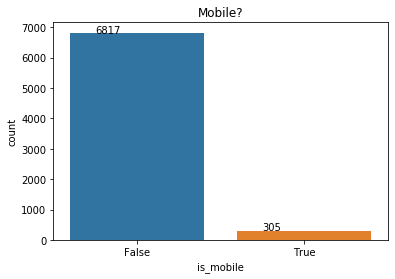

In [207]:
#Plotting propotions: Mobile phones
ax=sns.countplot(sample['is_mobile'])
plt.title("Mobile?")
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

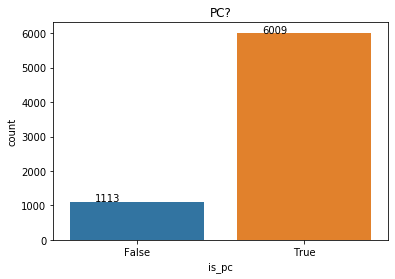

In [208]:
#Plotting propotions: Personal computers
ax=sns.countplot(sample['is_pc'])
plt.title("PC?")
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

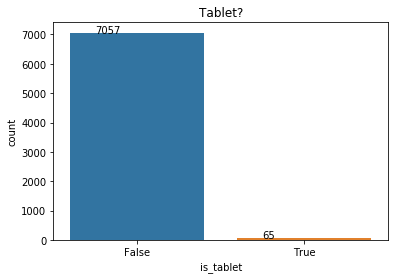

In [209]:
#Plotting propotions: Tablets
ax=sns.countplot(sample['is_tablet'])
plt.title("Tablet?")
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

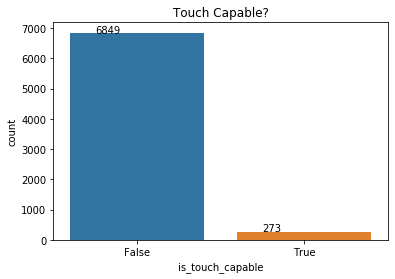

In [210]:
#Plotting propotions: Touch capable devices
ax=sns.countplot(sample['is_touch_capable'])
plt.title("Touch Capable?")
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

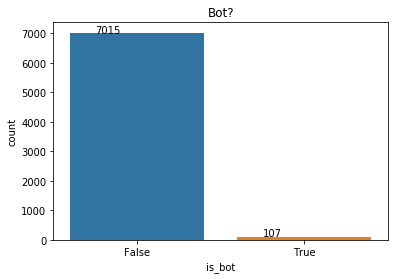

In [211]:
#Plotting propotions: Bots and crawlers
ax=sns.countplot(sample['is_bot'])
plt.title("Bot?")
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

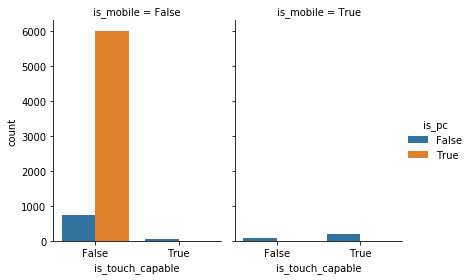

In [221]:
#Cross plotting: Mobile phones and touch capable devices
ax=sns.catplot(x="is_touch_capable", hue="is_pc", col="is_mobile",
...                 data=sample, kind="count",
...                 height=4, aspect=.7);


### Model Development (One Class SVM)

In [225]:
sample_cln=sample.drop(['index','user_agent','timestamp','timestamp_obj','min','os_version','browser_version','device_family','device_brand','device_model','user_id'],axis=1)

In [226]:
sample_cln=pd.concat([sample_cln,pd.get_dummies(sample_cln['os_family'])],axis=1).drop(['os_family'],axis=1)
sample_cln=pd.concat([sample_cln,pd.get_dummies(sample_cln['browser_family'])],axis=1).drop(['browser_family'],axis=1)

#### Training on 71 features; all categorical in nature including browser type but disregerding versioning information

In [227]:
# I make the assumption of 0.5% of samples being anomalies
X=sample_cln.values
clf = OneClassSVM(nu=0.005, kernel="rbf", gamma=0.1).fit(X)

In [228]:
result=clf.predict(X)

### Model Predictions (-1=Anomaly and 1=Normal)

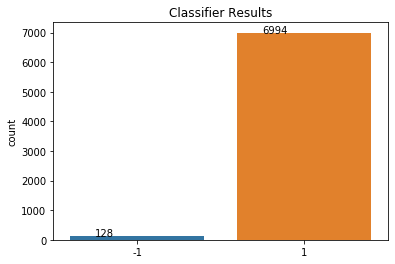

In [229]:
ax=sns.countplot(result)
plt.title("Classifier Results")
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

In [230]:
len(result[result==-1]),len(result[result==1])

(128, 6994)

####  1.8% of sample population appear to be outliers

In [231]:
(len(result[result==-1])/len(sample_cln))*100

1.7972479640550407

In [232]:
clf.score_samples(X) 

array([20.48174308, 21.19159522, 21.19159522, ..., 21.19159522,
       21.19159522, 21.08513182])

In [233]:
result_df=pd.DataFrame(result)
result_df.columns=['result']

In [234]:
sample_cln=pd.concat([sample_cln,result_df],axis=1)

In [235]:
sample_cln

,is_mobile,is_tablet,is_pc,is_touch_capable,is_bot,Android,BlackBerry OS,Linux,Mac OS X,Maemo,...,bitchcrawler,blocks/bot,bookmarksite_favicon,charlotte,divxcrawler,favicon,quot-bot,round-bot,scrape,result
0,True,False,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
1,False,False,True,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,False,False,True,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,False,False,True,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,False,False,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7117,False,False,True,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7118,False,False,True,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7119,False,False,True,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7120,False,False,True,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


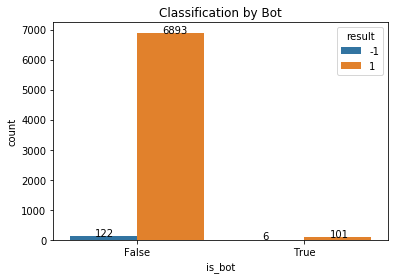

In [236]:
#Plotting results by Bot feature
ax=sns.countplot(x='is_bot',hue='result',data=sample_cln)
plt.title('Classification by Bot')
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

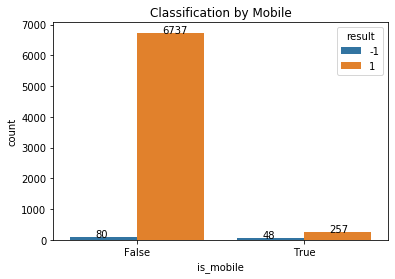

In [243]:
#Plotting results by Mobile feature
ax=sns.countplot(x='is_mobile',hue='result',data=sample_cln)
plt.title('Classification by Mobile')
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

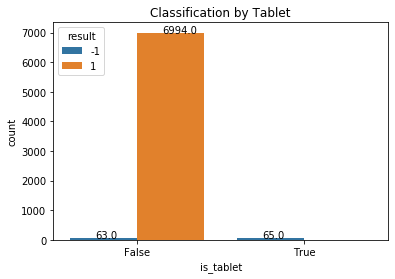

In [245]:
#Plotting results by Tablet feature
ax=sns.countplot(x='is_tablet',hue='result',data=sample_cln)
plt.title('Classification by Tablet')
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

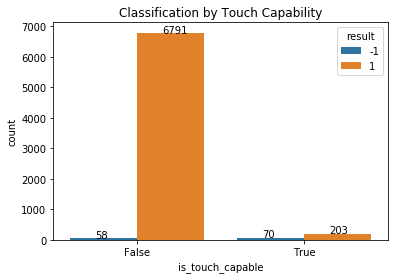

In [246]:
#Plotting results by Touch Capable feature
ax=sns.countplot(x='is_touch_capable',hue='result',data=sample_cln)
plt.title('Classification by Touch Capability')
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

#### Model appears to discriminate against mobile based traffic

In [85]:
sample_cln[result==-1]

,is_mobile,is_tablet,is_pc,is_touch_capable,is_bot,Android,BlackBerry OS,Linux,Mac OS X,Maemo,...,bitchcrawler,blocks/bot,bookmarksite_favicon,charlotte,divxcrawler,favicon,quot-bot,round-bot,scrape,result
0,True,False,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
6,False,True,False,True,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
59,True,False,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
332,False,True,False,True,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
340,False,True,False,True,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6850,False,True,False,True,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
7000,False,True,False,True,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
7022,False,True,False,True,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
7023,False,True,False,True,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1


In [162]:
#Persisting model parameters
train_columns=set(sample_cln.columns)-set('result')
train_columns_order=sample_cln.columns[:-1]
joblib.dump(train_columns,'train_columns.pkl')
joblib.dump(train_columns_order,'train_columns_order.pkl')
joblib.dump(clf,'clf.pkl')

['clf.pkl']

### Deployment code

In [10]:
#Loading model parameters
clf = joblib.load('clf.pkl')
train_columns =joblib.load('train_columns.pkl')
train_columns_order=joblib.load('train_columns_order.pkl')

In [24]:
def predict(ua_str,clf,train_columns,train_columns_order):
    benign=pd.DataFrame([ua_str])
    benign.columns=['user_agent']
    benign['timestamp']=benign['user_agent'].apply(lambda x: re.findall(r'^\[(.+?)\]',x)[0])
    benign['timestamp_obj']=benign['timestamp'].apply(lambda x:pd.to_datetime(x,format='%d/%b/%Y:%H:%M:%S -0700',errors='coerce'))
    benign['min']=benign['timestamp_obj'].apply(lambda x:(x.hour,x.minute))
    sample=benign
    sample['user_id']=benign['user_agent'].apply(lambda x: re.findall(r'user_\d+|Nico Rosberg',x)[0])
    sample['browser_family']=sample['user_agent'].apply(lambda x:parse(x).browser.family)
    sample['browser_version']=sample['user_agent'].apply(lambda x:parse(x).browser.version_string)
    sample['os_family']=sample['user_agent'].apply(lambda x:parse(x).os.family)
    sample['os_version']=sample['user_agent'].apply(lambda x:parse(x).os.version_string)
    sample['device_family']=sample['user_agent'].apply(lambda x:parse(x).device.family)
    sample['device_brand']=sample['user_agent'].apply(lambda x:parse(x).device.brand)
    sample['device_model']=sample['user_agent'].apply(lambda x:parse(x).device.model)
    sample['is_mobile']=sample['user_agent'].apply(lambda x:parse(x).is_mobile)
    sample['is_tablet']=sample['user_agent'].apply(lambda x:parse(x).is_tablet)
    sample['is_pc']=sample['user_agent'].apply(lambda x:parse(x).is_pc)
    sample['is_touch_capable']=sample['user_agent'].apply(lambda x:parse(x).is_touch_capable)
    sample['is_bot']=sample['user_agent'].apply(lambda x:parse(x).is_bot)
    sample_cln=sample.drop(['user_agent','timestamp','timestamp_obj','min','os_version','browser_version','device_family','device_brand','device_model'],axis=1)
    sample_cln=pd.concat([sample_cln,pd.get_dummies(sample_cln['os_family'])],axis=1).drop(['os_family'],axis=1)
    sample_cln=pd.concat([sample_cln,pd.get_dummies(sample_cln['browser_family'])],axis=1).drop(['browser_family'],axis=1)

        
    # Get columns missing from test sample
    missing_cols = train_columns - set(sample_cln.columns)
    # Add missing column and set to zero
    for c in missing_cols:
        sample_cln[c] = 0
    # Reset column order
    sample_cln = sample_cln[train_columns_order]
    
    X=sample_cln.values
    

    try:
        result=clf.predict(X)
        if result==1:
            classification='benign'
        else:
            classification='non_benign'
    
        msg=sample['user_id'][0]+' is '+classification+' ***  Browser:'+sample['browser_family'][0]+'  Mobile:'+ ('yes' if sample['is_mobile'][0] else 'no')
    
        return msg
    except:
        return 
           

### Bonus

In [ ]:
#Downloading data
!svn checkout https://github.com/jzadeh/aktaion/trunk/data/proxyData/exploitData

In [4]:
import os
data_dir='../../../exploitData/'
os.listdir(data_dir)

['.svn',
 '2014-01-02-neutrino-exploit-traffic.webgateway',
 '2014-01-07-neutrino-exploit-traffic.webgateway',
 '2014-01-09-DotkaChef-EK-traffic.webgateway',
 '2014-01-09-more-DotkaChef-EK-traffic.webgateway',
 '2014-01-13-Goon-EK-traffic.webgateway',
 '2014-01-14-magnitude-EK.webgateway',
 '2014-01-20-styx-EK-traffic.webgateway',
 '2014-01-21-Neutrino-EK-traffic.webgateway',
 '2014-01-24-Nuclear-EK-traffic.webgateway',
 '2014-01-26-Sweet-Orange-EK.webgateway',
 '2014-02-01-Fiesta-EK-silverlight.webgateway',
 '2014-02-02-Neutrino-EK-java-exploit.webgateway',
 '2014-02-02-Neutrino-EK-silverlight-exploit.webgateway',
 '2014-02-03-Goon-EK-traffic.webgateway',
 '2014-02-03-Neutrino-EK-traffic-01.webgateway',
 '2014-02-03-Neutrino-EK-traffic-02.webgateway',
 '2014-02-03-Nuclear-EK-traffic.webgateway',
 '2014-02-04-sweet-orange-EK-traffic.webgateway',
 '2014-02-07-Fiesta-EK-traffic.webgateway',
 '2014-02-09-Neutrino-EK-traffic.webgateway',
 '2014-02-11-Fiesta-EK-traffic.webgateway',
 '2014-0

In [7]:
def get_exploit_data():
    docs=os.listdir(data_dir)
    dfs=[]
    for doc in docs:
        if re.search(r'webgateway$',doc):
            doc_add=data_dir+doc
            f=open(doc_add)

            data =[]
            for x in f:
                data.append(x)
            f.close()

            exploit=pd.DataFrame(data)
            exploit.columns=['user_agent']
            exploit['source']=doc
            dfs.append(exploit)
        
    exploit_df=pd.concat(dfs,axis=0)
    
    return exploit_df     

exploit=get_exploit_data()

In [8]:
exploit=exploit.reset_index().drop(['index'],axis=1)

In [ ]:
exploit['predictions']=exploit['user_agent'].apply(lambda x: predict(x,clf,train_columns,train_columns_order))

In [43]:
result=exploit['predictions'].dropna().apply(lambda x: x[0])

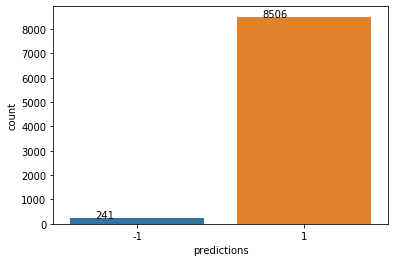

In [49]:
#Plotting results
ax=sns.countplot(result)
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

In [50]:
241/(8506+241)

0.027552303646964673

### 2.8% of exploit folder are classed as anomalies by the model